In [2]:
import numpy as np
import matplotlib.pyplot as plt

#settins for plots
matplotlib.rcParams['figure.figsize'] = (10,4)
matplotlib.rcParams['savefig.dpi'] = 100

In [3]:
#get the data from SensorCloud
repo = TimeSeriesRepo('OAPI00E2CHLYJR2Q')

#input data
dataSet1Label = 'Demo Normalized Data'
allSeries = repo.getAllTimeSeries( '1', 'ch1', startTime=1403106005087032000, endTime=1403106404542945000 )
series1 = allSeries[0]
timestamps = series1.getTimeStamps()
times = np.array(timestamps)

#convert timestamps into seconds for plotting
start = times[0]
times = (times - start)/1e9

#Get timeseries out of the data
values1 = np.array(series1.getData())

In [4]:
#determine if input length is prime number and adjust if necessary
def prime(n):
    if n<2:
        return False
    if n==2:
        return True
    if not n&1:
        return False
    for x in range(3, int(n**0.5)+1, 2):
        if n%x ==0:
            return False
    return True

isPrime = prime(len(values1))
print isPrime

t = True
while t == True:
    if isPrime == True:
        times = times[:-1]
        values1 = values1[:-1]
        isPrime = prime(len(values))
    if isPrime == False:
        t = False
    
    

False


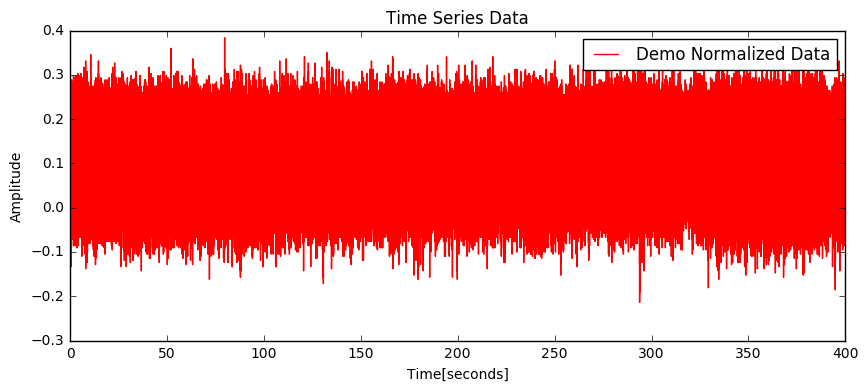

In [5]:
#plot the data
plt.plot(times, values1, color = 'r', label=dataSet1Label)
plt.title('Time Series Data')
plt.legend(loc='upper right')
plt.ylabel('Amplitude')
plt.xlabel('Time[seconds]')

In [6]:
#build FFT function

def getFft(values, samplerate, xMin = None, xMax = None):
    out = np.absolute(np.fft.fft(values))
    freq = np.fft.fftfreq(out.size, 1.0/samplerate)
    
    out = out[1:len(out)/2]
    freq = freq[1:len(freq)/2]
    
    if xMin == None or xMin < 0.1:
        xMin = 0.1
    for i, value in list(enumerate(freq)):
        if value >= xMin:
            freq = freq[i:]
            out = out[i:]
            break
    
    if xMax != None:
        for i, value in reversed(list(enumerate(freq))):
            if value <= xMax:
                freq = freq[:i]
                out = out[:i]
                break
        
    return (out, freq)
#FFT Algorithm written by Justin Bessette, LORD Corporation, 2014

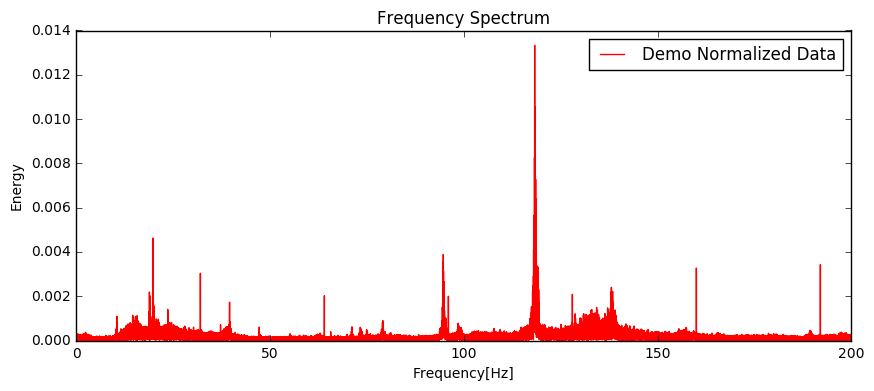

In [7]:
#FFT on the time series data
lowerLimit = 0 #hz
upperLimit = 200 #hz

fft1, freq1 = getFft(values1, series1.getSampleRate(), xMin = lowerLimit, xMax=upperLimit)
fft1 = fft1/float(len(values1)/2.0)
peak1 = np.argmax(fft1)

#plot the FFT
plt.plot(freq1, fft1, color='r', label=dataSet1Label)
plt.title('Frequency Spectrum')
plt.legend(loc='upper right')
plt.ylabel('Energy')
plt.xlabel('Frequency[Hz]')

#FFT Algorithm written by Justin Bessette, LORD Corporation, 2014

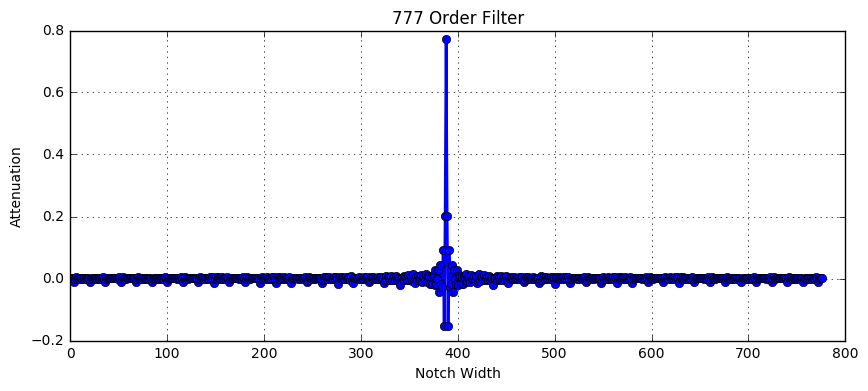

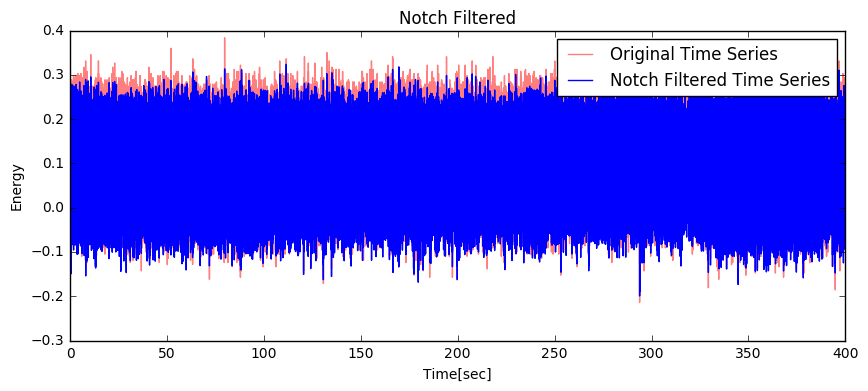

In [8]:
#build notch filter to remove RF artifact and harmonics
from scipy.signal import firwin, kaiserord, filtfilt

nyq_rate = (series1.getSampleRate()/2) #calculate signal Nyquist frequency

width = .6/nyq_rate #filter width

dip = 21.0 #desired attenuation

#compute filter coefficients
N, beta = kaiserord(dip, width)

#filter bandpass windows 0-f1, f2-f3, f4-f5,...etc 
cutoff_hz = [31.7, 32.3, 63.7, 64.3, 95.7, 96.3, 127.7, 128.3, 159.7, 160.3, 191.7, 192.3, 200.0] #cutoff of filter
cutoff_hz_nyq = []
#build bandpass window array normalized by nyquist frequency
for x in cutoff_hz:
    cutoff_hz_nyq.append(x/nyq_rate)

taps = firwin(N, cutoff_hz_nyq, window=('kaiser', beta))
#print len(taps)
filtered_x = filtfilt(taps, [1.0], values1)


plt.figure(1)
plt.plot(taps, 'bo-', linewidth=2)
plt.title('%d Order Filter' % N)
plt.ylabel('Attenuation')
plt.xlabel('Notch Width')
plt.grid(True)

plt.figure(2)
plt.plot(times, values1, 'r-', alpha=.5, label = 'Original Time Series')
plt.plot(times, filtered_x, 'b-', label = 'Notch Filtered Time Series')
plt.title('Notch Filtered')
plt.ylabel('Energy')
plt.xlabel('Time[sec]')
plt.legend(loc='upper right')

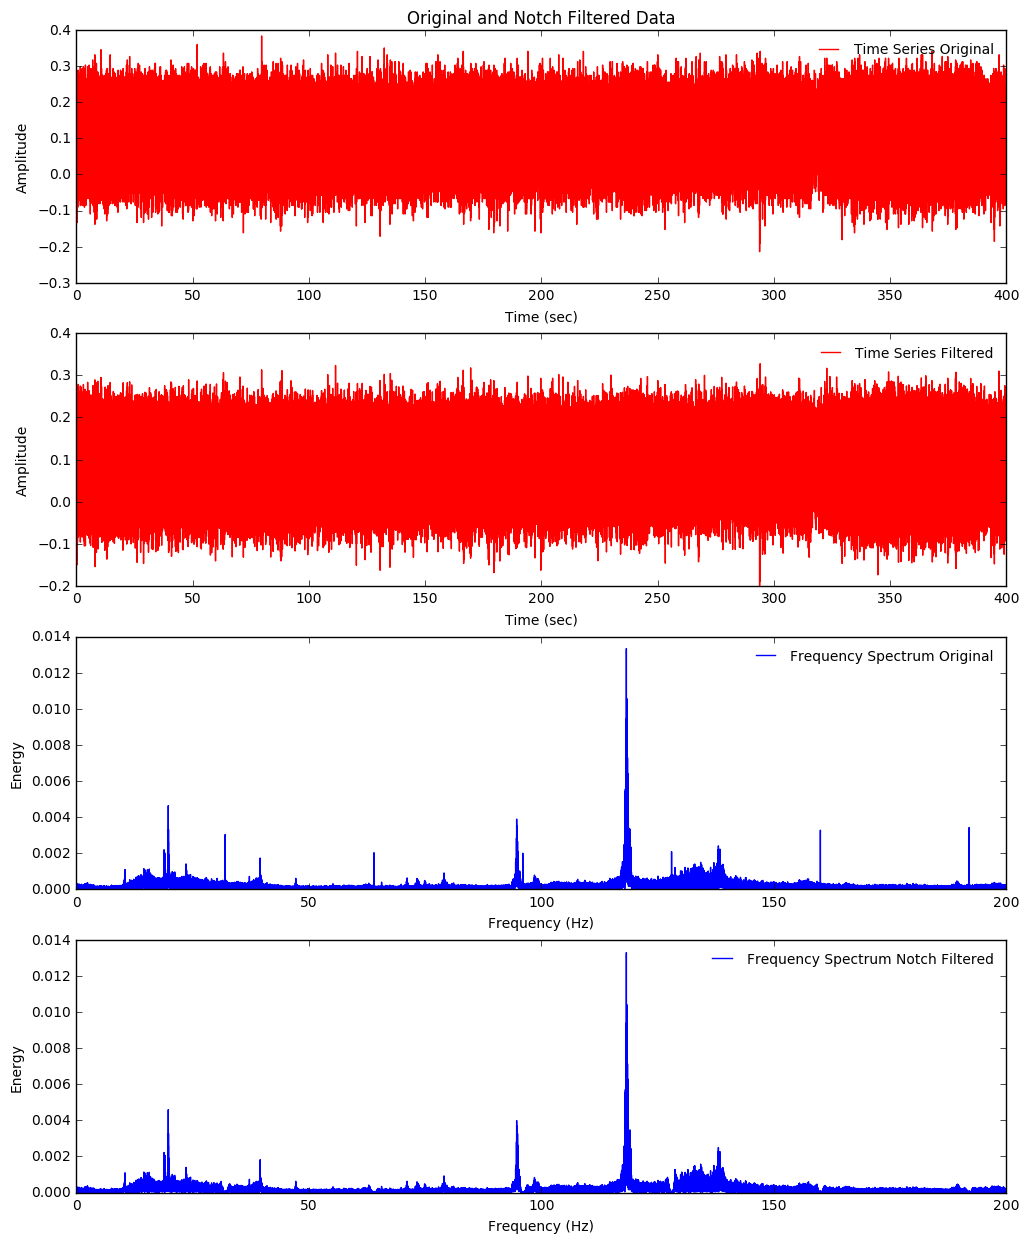

In [9]:
#fft on filtered data 
fft3, freq3 = getFft(filtered_x, series1.getSampleRate(), xMin = lowerLimit, xMax=upperLimit)
fft3 = fft3/float(len(filtered_x)/2.0)
peak3 = np.argmax(fft3)

#plot the Time Series comparison and the FFT comparison
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex = False, figsize=(12,15))

ax1.set_title('Original and Notch Filtered Data')

ax1.plot(times, values1, color='r', alpha=1, label='Time Series Original')
ax2.plot(times, filtered_x, color='r', alpha=1, label='Time Series Filtered')
ax3.plot(freq1, fft1, color='b', alpha=1, label='Frequency Spectrum Original')
ax4.plot(freq3, fft3, color='b', alpha=1, label='Frequency Spectrum Notch Filtered')

ax1.legend(frameon=False, fontsize=10)
ax2.legend(frameon=False, fontsize=10)
ax3.legend(frameon=False, fontsize=10)
ax4.legend(frameon=False, fontsize=10)
ax1.set_ylabel('Amplitude'); ax2.set_ylabel('Amplitude')
ax1.set_xlabel('Time (sec)'); ax2.set_xlabel('Time (sec)')
ax3.set_xlabel('Frequency (Hz)'); ax4.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Energy'); ax4.set_ylabel('Energy')

In [ ]:
#push data back to sensorcloud

#outData = zip(timestamps, filtered_x)

#outSeries = repo.createTimeSeries('1', 'ch1_Dan_Notch_Filter',series1.getSampleRate(), series1.getSampleRateType())

#outSeries.push(outData)

#outSeries.save()

#outSeries.tagAsMathengine()